In [1]:
from src.utils import get_data
from statsmodels.tsa.seasonal import seasonal_decompose

data = get_data('remaining_data_v1.csv')
data.set_index('timestamp', inplace=True)
data = data.resample('15min').last().dropna(subset=["close"])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/temirlanzholaman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
y = data['close']

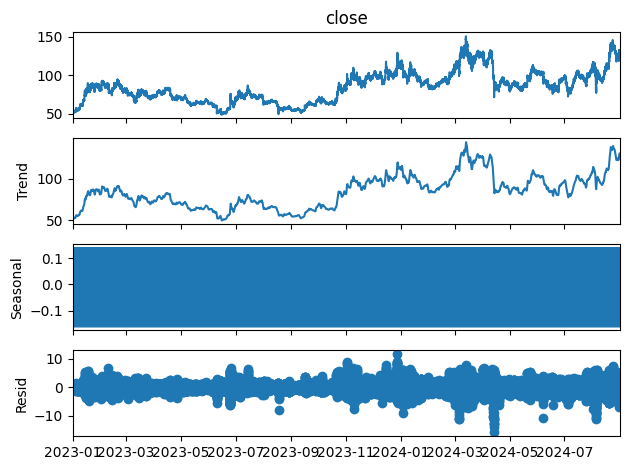

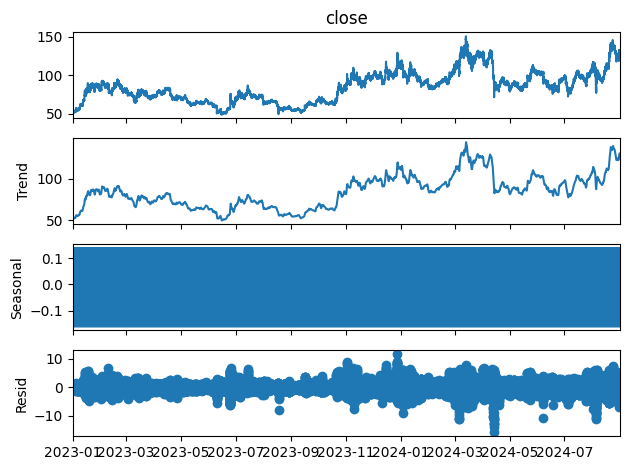

In [3]:
# Suppose 'y' is your time-series (pd.Series) with a DateTimeIndex
result = seasonal_decompose(y, model='additive', period=96)

# result.trend, result.seasonal, result.resid
result.plot()

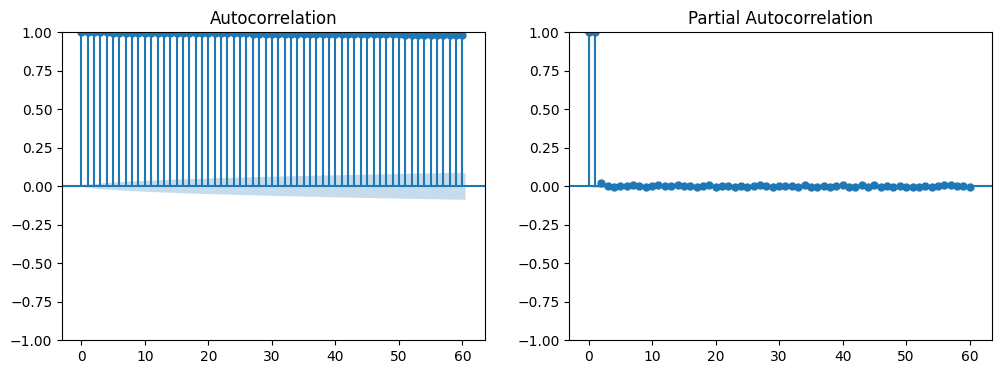

In [4]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1,2, figsize=(12,4))
plot_acf(y, ax=axes[0], lags=60)
plot_pacf(y, ax=axes[1], lags=60)
plt.show()


In [5]:
from statsmodels.tsa.stattools import adfuller, kpss

# ADF test
result_adf = adfuller(y)
print("ADF p-value:", result_adf[1])

# KPSS test
result_kpss = kpss(y, regression='c')
print("KPSS p-value:", result_kpss[1])


ADF p-value: 0.16941265580957626
KPSS p-value: 0.01


/var/folders/d4/kmvfs86566qdvphh5mdyn9lw0000gn/T/ipykernel_93917/3086308470.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result_kpss = kpss(y, regression='c')


kpss 0.01, lets assume stationarity xd

In [6]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test = acorr_ljungbox(y, lags=[10, 20, 30], return_df=True)
print(lb_test)


         lb_stat  lb_pvalue
10  5.827177e+05        0.0
20  1.162054e+06        0.0
30  1.738179e+06        0.0


# Auto Arima

In [7]:
from typing import List, Tuple
from src.utils import create_expanding_splits, compute_pnl
from pmdarima import auto_arima
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

def rolling_arima_evaluation(
    df: pd.DataFrame,
    val_windows: List[Tuple[str, str]],
    date_col: str = "timestamp",
    price_col: str = "price",
    pos_col: str = "pos_size"
):
    """
    For each expanding (train, val) fold:
      - Fit an auto_arima on train set (univariate).
      - Forecast the next len(val_df) points.
      - Build a naive position rule from forecast vs. actual.
      - Compute PnL on val set.
    Return average final PnL across folds, plus detail by fold.
    """

    folds = create_expanding_splits(df, val_windows, date_col=date_col)
    
    fold_results = []
    for i, (train_df, val_df) in tqdm(enumerate(folds, start=1)):
        if train_df.empty or val_df.empty:
            fold_results.append({"fold": i, "final_pnl": np.nan, "val_size": 0})
            continue
        train_series = train_df[price_col].astype(float).values
        model = auto_arima(
            train_series,
            start_p=0, start_q=0,
            max_p=5, max_q=5,
            seasonal=False,
            trace=False,
            error_action='ignore',
            suppress_warnings=True,
            stepwise=True
        )
        forecast_horizon = len(val_df)
        if forecast_horizon == 0:
            fold_results.append({"fold": i, "final_pnl": np.nan, "val_size": 0})
            continue
        preds = model.predict(n_periods=forecast_horizon)
        val_df = val_df.copy()
        val_df["forecast"] = preds
        difference = val_df["forecast"] - val_df[price_col]
        val_df[pos_col] = np.where(difference > 0, 1.0, -1.0)
        val_df = compute_pnl(val_df, pos_col=pos_col, price_col=price_col)
        final_pnl = val_df[f"{price_col}_cumulative_pnl"].iloc[-1]
        fold_results.append({
            "fold": i,
            "final_pnl": final_pnl,
            "val_size": len(val_df)
        })
    df_results = pd.DataFrame(fold_results)
    avg_pnl = df_results["final_pnl"].mean(skipna=True)

    return df_results, avg_pnl

In [8]:
data = get_data('remaining_data_v1.csv')
test_data = get_data('test_data.csv')

In [9]:
data.set_index('timestamp', inplace=True)
data = data.resample('15min').last().dropna(subset=["close"])

test_data.set_index('timestamp', inplace=True)
test_data = test_data.resample('15min').last().dropna(subset=["close"])

y_train_close = data['close'].astype(float).values
y_train_spread = data['spread'].astype(float).values

price_cols = ['close', 'spread']
n_test = len(test_data)

Cutoff: 2024-06-01


/Users/temirlanzholaman/anaconda3/envs/potykal/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/temirlanzholaman/anaconda3/envs/potykal/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


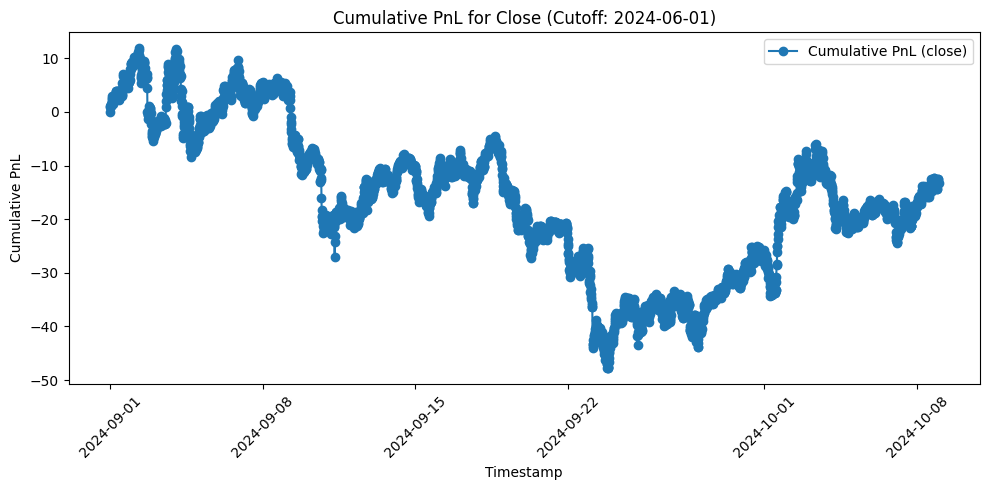

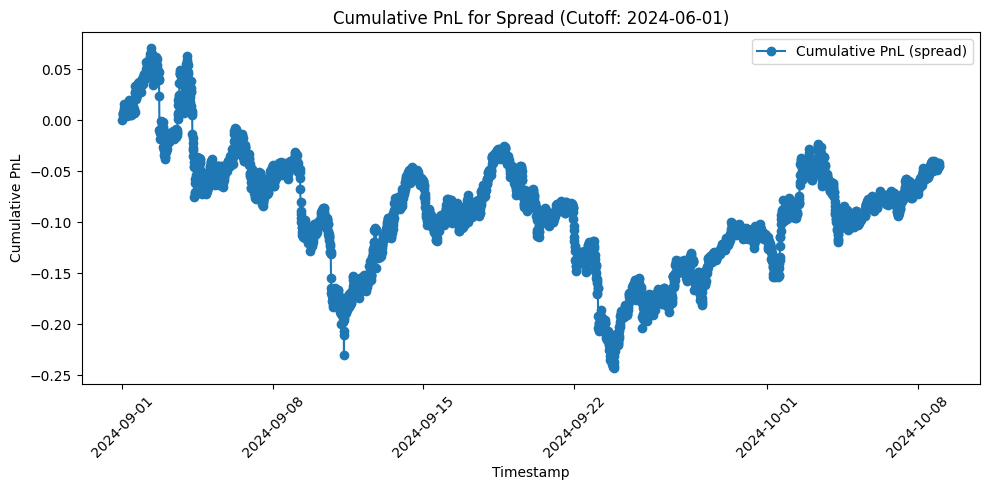

Final PnL (close): -13.230000000000018
Final PnL (spread): -0.04547729819360047


In [13]:
from typing import List, Tuple
from src.utils import create_expanding_splits, compute_pnl
from pmdarima import auto_arima
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
def rolling_arima_evaluation(
    df: pd.DataFrame,
    val_windows: List[Tuple[str, str]],
    date_col: str = "timestamp",
    price_col: str = "price",
    pos_col: str = "pos_size"
) -> Tuple[pd.DataFrame, float]:
    folds = create_expanding_splits(df, val_windows, date_col=date_col)
    fold_results = []
    
    for i, (train_df, val_df) in tqdm(enumerate(folds, start=1), total=len(folds), desc="Rolling ARIMA Folds"):
        if train_df.empty or val_df.empty:
            fold_results.append({"fold": i, "final_pnl": np.nan, "val_size": 0})
            continue
        train_series = train_df[price_col].astype(float).values
        model = auto_arima(
            train_series,
            start_p=0, start_q=0,
            max_p=5, max_q=5,
            seasonal=False,
            trace=False,
            error_action='ignore',
            suppress_warnings=True,
            stepwise=True
        )
        forecast_horizon = len(val_df)
        if forecast_horizon == 0:
            fold_results.append({"fold": i, "final_pnl": np.nan, "val_size": 0})
            continue
        preds = model.predict(n_periods=forecast_horizon)
        val_df = val_df.copy()
        val_df["forecast"] = preds
        difference = val_df["forecast"] - val_df[price_col]
        val_df[pos_col] = np.where(difference > 0, 1.0, -1.0)
        val_df = compute_pnl(val_df, pos_col=pos_col, price_col=price_col)
        final_pnl = val_df[f"{price_col}_cumulative_pnl"].iloc[-1]
        fold_results.append({
            "fold": i,
            "final_pnl": final_pnl,
            "val_size": len(val_df)
        })
        fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
        axes[0].plot(val_df[date_col], val_df[price_col], label="Actual", marker="o")
        axes[0].plot(val_df[date_col], val_df["forecast"], label="Forecast", linestyle="--")
        axes[0].set_title(f"Fold {i} - {price_col.capitalize()} Forecast vs. Actual")
        axes[0].legend()
        axes[1].plot(val_df[date_col], val_df[f"{price_col}_cumulative_pnl"], label="Cumulative PnL", color="green", marker="o")
        axes[1].set_title(f"Fold {i} - Cumulative PnL")
        axes[1].set_xlabel("Date")
        axes[1].legend()
        plt.tight_layout()
        plt.show()
    
    df_results = pd.DataFrame(fold_results)
    avg_pnl = df_results["final_pnl"].mean(skipna=True)
    return df_results, avg_pnl
def evaluate_cutoff_arima(
    cutoff: str,
    data: pd.DataFrame,
    test_data: pd.DataFrame,
    price_cols: List[str] = ['close', 'spread']
) -> dict:
    
    curr_data = data.reset_index()
    curr_data = curr_data[curr_data['timestamp'] < cutoff].set_index('timestamp')
    
    models = {}
    final_pnls = {}
    final_tests = {}
    for price_col in price_cols:
        series = curr_data[price_col].astype(float).values
        models[price_col] = auto_arima(
            series,
            start_p=0, start_q=0,
            max_p=5, max_q=5,
            seasonal=False,
            trace=False,
            error_action='ignore',
            suppress_warnings=True,
            stepwise=True
        )
    
    n_test = len(test_data)
    for price_col in price_cols:
        forecast_values = models[price_col].predict(n_periods=n_test)
        test_eval = test_data.copy()
        test_eval["forecast"] = forecast_values
        test_eval["difference"] = test_eval["forecast"] - test_eval[price_col]
        test_eval["pos_size"] = np.where(test_eval["difference"] > 0, 1.0, -1.0)
        
        test_eval = compute_pnl(test_eval, pos_col="pos_size", price_col=price_col)
        final_tests[price_col] = test_eval
        final_pnls[price_col] = test_eval[f"{price_col}_cumulative_pnl"].iloc[-1]
        plt.figure(figsize=(10, 5))
        plt.plot(test_eval.index, test_eval[f"{price_col}_cumulative_pnl"], marker="o", label=f"Cumulative PnL ({price_col})")
        plt.xlabel("Timestamp")
        plt.ylabel("Cumulative PnL")
        plt.title(f"Cumulative PnL for {price_col.capitalize()} (Cutoff: {cutoff})")
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    return final_pnls, final_tests
cutoffs = ['2024-06-01']
cutoff_results = {}
for cutoff in cutoffs:
    print("Cutoff:", cutoff)
    final_pnls, final_test_dfs = evaluate_cutoff_arima(cutoff, data, test_data, price_cols=['close', 'spread'])
    cutoff_results[cutoff] = final_pnls
    print("Final PnL (close):", final_pnls.get('close'))
    print("Final PnL (spread):", final_pnls.get('spread'))


In [29]:
xd = final_test_dfs['close'][['date', 'close_cumulative_pnl']].reset_index()
xd2 = final_test_dfs['spread'][['date', 'spread_cumulative_pnl']].reset_index()
xd3 = pd.merge(xd, xd2).drop('timestamp', axis=1)
xd3.columns = ['date', 'arima_close', 'arima_spread']
tot_data = pd.read_csv('tot_data.csv', parse_dates=['date']).drop('Unnamed: 0', axis=1,)
tot_data = pd.merge(tot_data, xd3, how='left')
tot_data.to_csv('tot_data.csv')
